In [1]:
import torch
import torch_scatter
import pickle
import random
import datetime

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import lightning as L

from urllib.parse import unquote
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import Dataset, random_split
from dataclasses import dataclass
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool

/Users/faustogerman/miniforge3/envs/geometric/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the text data

In [2]:
data = pd.read_csv(f"../../data/full_text_data.csv")
data

,title,plain_text
0,Áedán_mac_Gabráin,Áedán mac Gabráin\n\n2007 Schools Wikipedia Se...
1,Åland,Åland\n\n2007 Schools Wikipedia Selection. Rel...
2,Édouard_Manet,Édouard Manet\n\n2007 Schools Wikipedia Select...
3,Éire,Éire\n\n2007 Schools Wikipedia Selection. Rela...
4,Óengus_I_of_the_Picts,Óengus I of the Picts\n\n2007 Schools Wikipedi...
...,...,...
4599,Zionism,Zionism\n\n2007 Schools Wikipedia Selection. R...
4600,Zirconium,Zirconium\n\n2007 Schools Wikipedia Selection....
4601,Zoroaster,Zoroaster\n\n2007 Schools Wikipedia Selection....
4602,Zuid-Gelders,Zuid-Gelders\n\n2007 Schools Wikipedia Selecti...


### Load the links

In [3]:
links = pd.read_csv("../../data/Wikispeedia/links.tsv", sep="\t", names=["src", "tgt"], skiprows=12)
links

,src,tgt
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland
...,...,...
119877,Zulu,South_Africa
119878,Zulu,Swaziland
119879,Zulu,United_Kingdom
119880,Zulu,Zambia


#### Create an adjacency matrix from the links

In [4]:
links["src"] = links["src"].map(lambda x: unquote(x))
links["tgt"] = links["tgt"].map(lambda x: unquote(x))

ordered_data_titles = data["title"].tolist()

src_indices = links["src"].map(lambda x: ordered_data_titles.index(x))
tgt_indices = links["tgt"].map(lambda x: ordered_data_titles.index(x))

A = torch.zeros((len(ordered_data_titles), len(ordered_data_titles)))
A[src_indices, tgt_indices] = 1

A  # This is the base structure of the Wikipedia network

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

### Load the coherence graph

In [5]:
with open("../../data/coherence_graph.pkl", 'rb') as handle:
    coherence_graph = pickle.load(handle)
    print(f"Coherence graph loaded successfully.")

coherence_graph

Coherence graph loaded successfully.


array([[0.        , 0.33138034, 0.31785333, ..., 0.33416559, 0.3096299 ,
        0.3338204 ],
       [0.33138034, 0.        , 0.31811661, ..., 0.59573573, 0.34740373,
        0.66406903],
       [0.31785333, 0.31811661, 0.        , ..., 0.32476778, 0.30271915,
        0.32060009],
       ...,
       [0.33416559, 0.59573573, 0.32476778, ..., 0.        , 0.31785316,
        0.67388399],
       [0.3096299 , 0.34740373, 0.30271915, ..., 0.31785316, 0.        ,
        0.33336595],
       [0.3338204 , 0.66406903, 0.32060009, ..., 0.67388399, 0.33336595,
        0.        ]])

### Combine the Coherence Graph and Base Links to form Semantic Network

In [6]:
edge_features = A * coherence_graph
edge_features  # This is the base structure of the Wikipedia network, with coherence scores as edge features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

### Load the Node Features (OpenAI Embeddings)

In [7]:
with open("../../data/gpt4_embeddings.pkl", 'rb') as handle:
    obj = pickle.load(handle)
    node_static_embeddings = obj["embeddings"]
    del obj
    print(f"File '../../data/gpt4_embeddings.pkl' loaded successfully.")

File '../../data/gpt4_embeddings.pkl' loaded successfully.


### Load the User-Extracted Paths

In [8]:
paths_data = pd.read_csv(f"../../data/paths_no_back_links.tsv", sep="\t")
paths_data = paths_data[~(paths_data["rating"].isna())]

paths_data

,hashedIpAddress,timestamp,durationInSec,path,rating
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
6,36dabfa133b20e3c,1249525912,112,14th_century;China;Gunpowder;Fire,2.0
7,20418ff4797f96be,1229188046,139,14th_century;Time;Isaac_Newton;Light;Color;Rai...,1.0
8,08888b1b428dd90e,1232241510,74,14th_century;Time;Light;Rainbow,3.0
...,...,...,...,...,...
51310,55150dce4acb74c8,1340891297,117,Women%27s_rights;Property;Clothing;Weather;Autumn,5.0
51311,4753cde919cd5ce5,1348670636,418,Work_%28thermodynamics%29;Energy;Aristotle;Poe...,3.0
51312,052ba30a41ff5a05,1371787558,133,Work_%28thermodynamics%29;Cambridge;City_statu...,3.0
51314,2ef7ac844cefda58,1300254138,165,Yagan;Folklore;Brothers_Grimm;Folklore;19th_ce...,3.0


<Axes: >

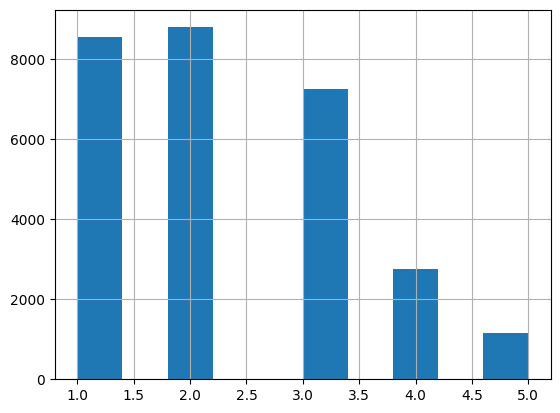

In [9]:
paths_data["rating"].hist()

In [10]:
# Find the minimum count of rows for any rating
min_count = paths_data['rating'].value_counts().min()

# Perform uniform sampling for each rating
paths_data = paths_data.groupby('rating').apply(
    lambda x: x.sample(min_count, replace=False, random_state=420),
    include_groups=False
).reset_index(level=1, drop=True).reset_index()

paths_data

,rating,hashedIpAddress,timestamp,durationInSec,path
0,1.0,5faa6cea3e23e965,1261254125,85,Bran;United_States;New_York_City
1,1.0,0d57c8c57d75e2f5,1281965993,45,Odin;Roman_Empire;Rome;Vatican_City;Pope
2,1.0,73ab206d704e899d,1260232180,90,Society;Switzerland;Russia;North_Sea
3,1.0,0d57c8c57d75e2f5,1290086997,522,Saturn_V;United_States;Ethnic_group;Africa;Mau...
4,1.0,59450a9d37ceeb10,1250266933,75,DNA;Plant;Carbon_dioxide
...,...,...,...,...,...
5785,5.0,25e30db000ae5901,1249418314,1972,Battle_of_Gettysburg;American_Civil_War;Europe...
5786,5.0,275ddcef542ee780,1248703655,270,Spinosaurus;Egypt;Sudan;Ethiopia;Africa;Ethiop...
5787,5.0,267dccdc349d1f7a,1250456630,1051,Tin_whistle;The_Great_Exhibition;Karl_Marx;Ger...
5788,5.0,63c4f41031aef65b,1302397949,250,Theatre;Drama;Film;Animation;Motion_%28physics...


<Axes: >

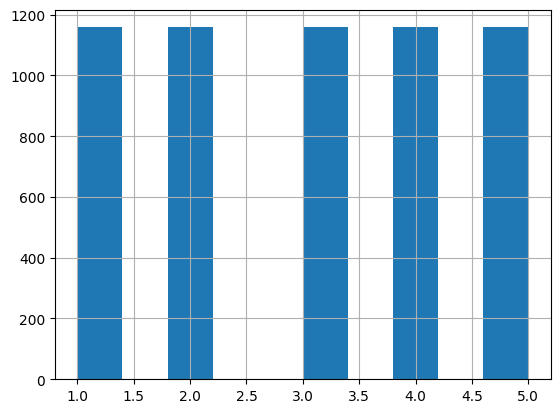

In [11]:
paths_data["rating"].hist()

#### Map the Path Titles to Node Indices

In [12]:
# Create a mapping from title to index
title_to_index = {unquote(title): idx for idx, title in enumerate(data['title'])}

# Convert each path to a list of indices
paths = paths_data['path'].apply(
    lambda path: [title_to_index[unquote(title)] for title in path.split(';')]
).tolist()

# Ratings start at 1. We make them 0-indexed here to be compatible with CrossEntropyLoss
ratings = (paths_data['rating'] - 1).tolist()

### Create Datasets and Data Loaders with Batched Path Subgraphs

In [13]:
class PathDataset(Dataset):
    def __init__(self, all_padded_paths, ratings, node_static_embeddings, edge_features):
        self.all_padded_paths = all_padded_paths
        self.ratings = ratings
        self.node_static_embeddings = node_static_embeddings
        self.edge_features = edge_features

    def __len__(self):
        return len(self.all_padded_paths)

    def __getitem__(self, idx):
        path = self.all_padded_paths[idx]
        rating = self.ratings[idx]

        # Extract the 1-hop neighborhood subgraph
        neighbors, in_path, subgraph, edges = self.get_path_1hop_neighborhood(
            path,
            self.edge_features
        )

        # Get node features
        node_features = self.node_static_embeddings[neighbors]

        # Create edge index tensor
        if len(edges) > 0:
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)

        # Create the Data object
        node_data = Data(
            x=node_features,
            edge_index=edge_index,
            y=torch.tensor([rating], dtype=torch.float),
            in_path=torch.tensor(in_path, dtype=torch.float),
            # We convert the subgraph to numpy to avoid issues with PyTorch's Data collation,
            # since the subgraphs have shape NxN, instead of NxD. That is they do not have
            # fixed feature dimensionality in the columns. The columns vary with the rows.
            adj=subgraph.numpy()
        )

        return node_data

    def get_path_1hop_neighborhood(self, path, edge_features, do_shuffle=False):
        path_nodes = set(path)

        # Collect 1-hop neighbors in a set to avoid duplicates
        neighbors = set()
        for node in path:
            neighbors.update(edge_features[node].nonzero().squeeze(1).tolist())

        all_nodes = list(path_nodes | neighbors)

        if do_shuffle:
            random.shuffle(all_nodes)

        # Extract subgraph using tensor indexing
        indices = torch.tensor(all_nodes)
        subgraph = edge_features.index_select(0, indices).index_select(1, indices)

        # Create a binary list indicating if each node is in the path
        is_in_path = [1 if node in path_nodes else 0 for node in all_nodes]

        # Edge list from non-zero entries in the subgraph
        edge_indices = (subgraph != 0).nonzero(as_tuple=False)
        edge_list = [(src.item(), tgt.item()) for src, tgt in edge_indices]

        return all_nodes, is_in_path, subgraph, edge_list

In [14]:
batch_size = 2  # only works with batch size of 1

# Define the split ratio (e.g., 80% for training, 20% for testing)
train_ratio = 0.85
val_ratio = 0.05
test_ratio = 0.1

number_of_paths = len(paths)

# Calculate the sizes of the splits
train_size = int(train_ratio * number_of_paths)
val_size = int(val_ratio * number_of_paths)
test_size = number_of_paths - train_size - val_size

print("Number of Training Samples:", train_size)
print("Number of Validation Samples:", val_size)
print("Number of Testing Samples:", test_size)

full_paths_dataset = PathDataset(
    paths,
    ratings,
    node_static_embeddings,
    edge_features,
)

# Split the dataset
train_dataset, test_dataset, val_dataset = random_split(
    dataset=full_paths_dataset,
    lengths=[train_size, test_size, val_size]
)

# Create data loaders (optional, but recommended for efficient training)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Number of Training Samples: 4921
Number of Validation Samples: 289
Number of Testing Samples: 580


## The Model

In [15]:
class GraphSAGELayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GraphSAGELayer, self).__init__()
        self.out_feats = out_feats
        self.linear_self = nn.Linear(in_feats, out_feats)
        self.linear_neigh = nn.Linear(in_feats, out_feats)
        self.output_linear = nn.Linear(2 * out_feats, out_feats)

        self.apply(self._init_weights)

    def _init_weights(self, module): 
        if isinstance(module, nn.Linear):
            # torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def forward(self, x, edge_index):
        # x: Node features [num_nodes, in_feats]
        # edge_index: Graph connectivity [2, num_edges]
        # edge_attr: Edge features [num_edges, edge_attr_dim], optional

        num_nodes = x.size(0)

        # Compute self node embeddings
        h_self = F.leaky_relu(self.linear_self(x))  # [num_nodes, out_feats]

        # Neighbor node indices and features
        src_nodes = edge_index[0]  # Source nodes (neighbors)
        dst_nodes = edge_index[1]  # Target nodes

        # Neighbor features
        x_neigh = x[src_nodes]  # [num_edges, in_feats]

        # Linear transformation on neighbor features
        h_neigh = F.leaky_relu(self.linear_neigh(x_neigh))  # [num_edges, out_feats]

        # Aggregate neighbor messages using max pooling
        h_neigh_agg = torch_scatter.scatter_max(
            src=h_neigh,
            index=dst_nodes,
            dim=0,
            dim_size=num_nodes
        )[0]

        # Handle nodes with no incoming edges
        h_neigh_agg[h_neigh_agg == float('-inf')] = 0

        # Concatenate self and neighbor embeddings
        # [num_nodes, 2 * out_feats]
        h_concat = torch.cat([h_self, h_neigh_agg], dim=1)

        # Output transformation
        h_out = F.leaky_relu(self.output_linear(h_concat))  # [num_nodes, out_feats]

        return h_out


class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GraphSAGE, self).__init__()
        self.layer1 = GraphSAGELayer(in_feats, hidden_feats)
        self.layer2 = GraphSAGELayer(hidden_feats, hidden_feats)
        self.layer3 = GraphSAGELayer(hidden_feats, out_feats)

    def forward(self, x, edge_index):
        h1 = self.layer1(x, edge_index)
        h2 = self.layer2(h1, edge_index)
        h3 = self.layer3(h2, edge_index)

        return h3

In [16]:
class Model(nn.Module):
    def __init__(self, node_in_feats, k_edge_features, hidden_feats, out_feats, class_feats, num_classes, dropout=0.2, bias=True):
        super(Model, self).__init__()
        self.k_edge_features = k_edge_features

        self.node_features_embeds = GraphSAGE(node_in_feats + 1, hidden_feats, out_feats)
        self.edge_eigen_mapping = nn.Linear(k_edge_features, node_in_feats)
        self.edge_features_embeds = GraphSAGE(node_in_feats + 1, hidden_feats, out_feats)

        self.classifier_head = nn.Sequential(
            # Concatenated node and edge embeddings
            nn.Linear((out_feats * 2) + 1, class_feats, bias=bias),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(class_feats, class_feats, bias=bias),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(class_feats, num_classes, bias=bias)
        )

        self.apply(self._init_weights)

    def _init_weights(self, module): 
        if isinstance(module, nn.Linear):
            # torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def forward(self, node_features, edge_subgraph, edge_list, is_in_path, batch_mask):
        # The node features
        node_features = torch.cat((is_in_path, node_features), dim=1)
        
        # The edge features (as eigenvectors)
        # Remember that edge_subgraph is a list of subgraphs as numpy arrays. We need to convert them to tensors
        # and then compute the eigenvectors for each subgraph before concatenating them.
        collected_edge_features = []
        for subgraph in edge_subgraph:
            edge_features = self.get_k_eigenvecs(torch.from_numpy(subgraph), self.k_edge_features)
            edge_features = self.edge_eigen_mapping(edge_features.to(torch.float32))
            collected_edge_features.append(edge_features)

        # Concatenate the edge features
        collected_edge_features = torch.cat(collected_edge_features, dim=0)
        collected_edge_features = torch.cat((is_in_path, collected_edge_features), dim=1)

        # The node and edge GraphSAGE embeddings
        edge_embeds = self.edge_features_embeds(collected_edge_features, edge_list)
        node_embeds = self.node_features_embeds(node_features, edge_list)

        # Combine the node and edge embeddings
        h = torch.cat((is_in_path, node_embeds, edge_embeds), dim=1)

        # The classifier head
        out = self.classifier_head(h)
        out = global_mean_pool(out, batch_mask)

        return out

    def get_k_eigenvecs(self, edge_features, k):
        # Compute eigenvalues and eigenvectors of L
        eigenvalues, eigenvectors = torch.linalg.eigh(edge_features)  # eigenvalues in ascending order

        # Identify non-zero (non-trivial) eigenvalues
        eps = 1e-5  # Tolerance for zero
        non_zero_indices = (eigenvalues > eps).nonzero(as_tuple=True)[0]

        # Handle the case when there are fewer than k non-zero eigenvalues
        if len(non_zero_indices) < k:
            raise ValueError(f"Not enough non-trivial eigenvalues, got {len(non_zero_indices)}, need {k}")

        # Get the indices of the k largest non-zero eigenvalues
        k_largest_indices = non_zero_indices[-k:]

        # Get the corresponding eigenvectors
        k_largest_eigenvectors = eigenvectors[:, k_largest_indices]

        return k_largest_eigenvectors

In [17]:
MODEL = Model(
    node_static_embeddings.shape[1],
    k_edge_features=10,  # Number of eigenvectors to use
    hidden_feats=1024,  # Hidden layer size for GraphSAGE
    out_feats=768,  # Output layer size for GraphSAGE
    class_feats=256,  # Hidden layer size for the classifier head
    num_classes=5,  # Number of classes
)

In [18]:
class LitModel(L.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config

    def training_step(self, batch, batch_idx):
        logits = self.do_forward(batch)
        loss = self.compute_loss(logits, batch.y)

        loss = self.compute_loss(logits, batch.y)
        acc = self.compute_accuracy(logits, batch.y)

        # Log training loss and accuracy
        self.log("training_loss", loss, on_step=True, on_epoch=True, logger=True, batch_size=batch_size)
        self.log("training_accuracy", acc, on_step=True, on_epoch=True, logger=True, batch_size=batch_size)

        return loss

    def test_step(self, batch):
        logits = self.do_forward(batch)

        loss = self.compute_loss(logits, batch.y)
        acc = self.compute_accuracy(logits, batch.y)

        self.log("test_loss", loss, on_step=True, on_epoch=True, batch_size=batch_size)
        self.log("test_accuracy", acc, on_step=True, on_epoch=True, batch_size=batch_size)

    def validation_step(self, batch, batch_idx):
        logits = self.do_forward(batch)

        loss = self.compute_loss(logits, batch.y)
        acc = self.compute_accuracy(logits, batch.y)

        # Log validation loss and accuracy
        self.log("validation_loss", loss, on_step=True, on_epoch=True, logger=True, batch_size=batch_size)
        self.log("validation_accuracy", acc, on_step=True, on_epoch=True, logger=True, batch_size=batch_size)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            params=self.model.parameters(),
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay,
            betas=(self.config.beta1, self.config.beta2),
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": ReduceLROnPlateau(optimizer),
                "interval": "epoch",
                "frequency": 1,
                "monitor": "validation_loss",
                "strict": True,
            }
        }

    def do_forward(self, batch):
        """This is a custom method not associated with Lightning"""
        return self.model(
            node_features=batch.x,
            edge_subgraph=batch.adj,
            edge_list=batch.edge_index,
            is_in_path=batch.in_path.unsqueeze(1), 
            batch_mask=batch.batch
        )

    def compute_loss(self, logits, targets):
        """This is a custom method not associated with Lightning"""
        targets = targets.type(torch.long)
        return F.cross_entropy(logits, targets)

    def compute_accuracy(self, logits, targets):
        """This is a custom method not associated with Lightning"""
        return (logits.argmax(1) == targets).float().mean()

In [19]:
@dataclass
class ModelConfig:
    learning_rate: float = 1e-4
    weight_decay: float = 1e-2
    beta1: float = 0.9
    beta2: float = 0.999
    grad_clip: float = 1.0
    num_epochs: int = 10
    log_interval: int = 10
    grad_accumulation: int = 16
    wandb_project: str = "wikispeedia"


config = ModelConfig()

In [ ]:
# model
transformer = LitModel(MODEL, config)

# logging
wandb_logger = WandbLogger(
    project=config.wandb_project,
    name=datetime.datetime.now().strftime("%b-%d-%y @ %I:%M %p"),
    log_model="all",
    config=config
)

# wandb_logger.watch(MODEL, log="all")

# Define the trainer
trainer = L.Trainer(
    default_root_dir="some/path/",
    max_epochs=config.num_epochs,
    val_check_interval=0.5,
    log_every_n_steps=config.log_interval,
    accumulate_grad_batches=config.grad_accumulation,
    gradient_clip_val=config.grad_clip,
    profiler="simple",
    logger=wandb_logger,
    # NOTE: Should be commented out if using GPU. There may be bugs related
    # to tensor device placements, since I have not tested this on GPU.
    accelerator="cpu",
)

# train model
trainer.fit(
    model=transformer,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/faustogerman/miniforge3/envs/geometric/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: faustotnc. Use `wandb login --relogin` to force relogin



  | Name  | Type  | Params | Mode 
----------------------------------------
0 | model | Model | 24.9 M | train
----------------------------------------
24.9 M    Trainable params
0         Non-trainable params
24.9 M    Total params
99.512    Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/faustogerman/miniforge3/envs/geometric/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/faustogerman/miniforge3/envs/geometric/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0:   5%|▌         | 135/2461 [02:30<43:18,  0.90it/s, v_num=hr1m]

In [ ]:
# Test the model
trainer.test(model=transformer, dataloaders=test_loader)

In [21]:
MODEL = MODEL.eval()
i = iter(test_loader)

In [ ]:
test_batch = next(i)

MODEL(
    node_features=test_batch.x,
    edge_subgraph=test_batch.adj,
    edge_list=test_batch.edge_index,
    is_in_path=test_batch.in_path.unsqueeze(1),
    batch_mask=test_batch.batch
)

In [ ]:
test_batch.y